In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from lungmask import LMInferer
rootpath = "//Zkh/appdata/RTDicom/DAMEproject/LUNGSABR_data_2022/NIFTI_v0/0843413/"

C:\Users\delaoArevaLR\AppData\Local\anaconda3\envs\Ch2_July23_2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def cropLungMask(ct_image,rt_image=None):
    kdiv =64
    inferer = LMInferer()
    lungmask = inferer.apply(ct_image)
    ct_array = sitk.GetArrayFromImage(ct_image)
    mask_array = lungmask
    
    mask_bb = np.where(mask_array>0)
    min_indices = [np.min(bb) for bb in mask_bb]
    max_indices = [np.max(bb) for bb in mask_bb]
    
    padding = kdiv - ((max_indices[0] - min_indices[0] + 1) % kdiv)
    padding = max(0, padding)  # Ensure padding is non-negative
    padding=0
    min_indices = [max(0, idx - padding) for idx in min_indices]
    max_indices = [min(dim_size - 1, idx + padding) for idx, dim_size in zip(max_indices, ct_array.shape)]

    cropped_ct_array = ct_array[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]
    cropped_ct_image = sitk.GetImageFromArray(cropped_ct_array)
    cropped_ct_image.SetOrigin(ct_image.GetOrigin())
    cropped_ct_image.SetSpacing(ct_image.GetSpacing())

    cropped_mask_array = mask_array[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]
    cropped_mask_image = sitk.GetImageFromArray(cropped_mask_array)
    cropped_mask_image.SetOrigin(cropped_mask_image.GetOrigin())
    cropped_mask_image.SetSpacing(cropped_mask_image.GetSpacing())

    
    if rt_image is not None:
        rt_array = sitk.GetArrayFromImage(rt_image)
        cropped_rt_array = rt_array[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]
        cropped_AidditionalImage = sitk.GetImageFromArray(cropped_rt_array)
        cropped_AidditionalImage.SetOrigin(cropped_AidditionalImage.GetOrigin())
        cropped_AidditionalImage.SetSpacing(cropped_AidditionalImage.GetSpacing())

        return cropped_ct_image,cropped_mask_image,cropped_AidditionalImage
            
    else:
        return cropped_ct_image,cropped_mask_image
    
    

In [3]:
image_50 = sitk.ReadImage(rootpath+"0843413_T=50%,PR=44% - 54%,AR()=70 - 78_ct.nii.gz")
image_60 = sitk.ReadImage(rootpath+"0843413_T=60%,PR=55% - 64%,AR()=67 - 79_ct.nii.gz")
image_00 = sitk.ReadImage(rootpath+"0843413_T=0%,PR=96% - 5%,AR()=25 - 39_ct.nii")
gtv_image =  sitk.ReadImage(rootpath+"0843413_rtstruct_GTV.nii.gz")

In [4]:
#Prepare 50% BP
image50_crop,image50_lungmask,gtv_crop = cropLungMask(image_50,gtv_image)
print(sitk.GetArrayFromImage(image50_lungmask).shape,sitk.GetArrayFromImage(image50_crop).shape,sitk.GetArrayFromImage(gtv_crop).shape)
image50_cropClamp = sitk.Clamp(image50_crop, lowerBound=-1024, upperBound=600)
array50_cropClamp = sitk.GetArrayFromImage(image50_cropClamp)
array50_lungmask= sitk.GetArrayFromImage(image50_lungmask)
arraygtv_50 = sitk.GetArrayFromImage(gtv_crop)

10it [00:05,  1.88it/s]                        

lungmask 2023-11-27 17:06:11 Postprocessing



100%|██████████| 16/16 [00:00<00:00, 41.23it/s]


(90, 148, 228) (90, 148, 228) (90, 148, 228)


In [5]:
#Prepare 00 BP
image00_crop,image00_lungmask = cropLungMask(image_00)
image00_cropClamp = sitk.Clamp(image00_crop, lowerBound=-1024, upperBound=600)
array00_cropClamp = sitk.GetArrayFromImage(image00_cropClamp)
array00_lungmask= sitk.GetArrayFromImage(image00_lungmask)

10it [00:02,  3.85it/s]                        

lungmask 2023-11-27 17:06:18 Postprocessing



100%|██████████| 18/18 [00:00<00:00, 37.36it/s]


In [6]:
array50_lungmask.shape,array00_lungmask.shape

((90, 148, 228), (99, 149, 232))

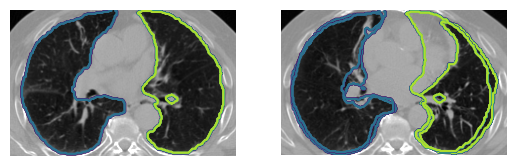

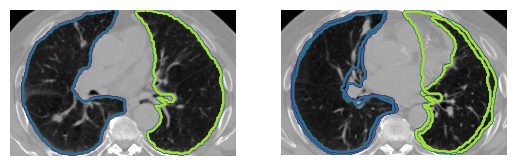

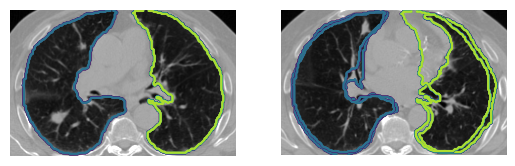

In [10]:
count=0
for i in range(arraygtv_50.shape[-3]):
    if np.sum(arraygtv_50[i,:,:])>0:
        plt.subplot(121),plt.imshow(array50_cropClamp[i,:,:],cmap='gray'),plt.axis("off")
        #plt.contour(arraygtv_50[i,:,:])
        plt.contour(array50_lungmask[i,:,:])
        plt.subplot(122),plt.imshow(array00_cropClamp[i,:,:],cmap='gray'),plt.axis("off")
        #plt.contour(arraygtv_50[i,:,:])
        plt.contour(array00_lungmask[i,:,:])   
        plt.contour(array50_lungmask[i,:,:])
        plt.show()
        count+=1
        if count>2:
            break
        

In [11]:
fixed_image = image00_lungmask
moving_image = image50_lungmask
fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)

In [12]:
control_point = 3
order = 1

registration_method = sitk.ImageRegistrationMethod()
#Metrics
registration_method.SetMetricAsCorrelation()
#registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.3)
#Optimizer
registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=0.1, minStep=1e-4, numberOfIterations=200)
bspline_transform = sitk.BSplineTransformInitializer(fixed_image, transformDomainMeshSize=[control_point]*fixed_image.GetDimension(), order=order)
registration_method.SetInitialTransform(bspline_transform, inPlace=False)
registration_method.SetShrinkFactorsPerLevel([4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel([2, 1, 0])

# Perform the registration
final_transform = registration_method.Execute(fixed_image, moving_image)
evaluation_metric = registration_method.GetMetricValue()
initial_metric_value = registration_method.MetricEvaluate(fixed_image, moving_image)
print(f"Initial metric value: {initial_metric_value}")
print(f"Final metric value: {evaluation_metric}")

# Resample the moving image using the final transform
resampled_image = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkNearestNeighbor , 0.0, moving_image.GetPixelID())
print(sitk.GetArrayFromImage(resampled_image).shape)


Initial metric value: -0.4579371348379384
Final metric value: -0.9191163477009252
(99, 149, 232)


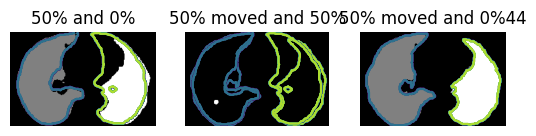

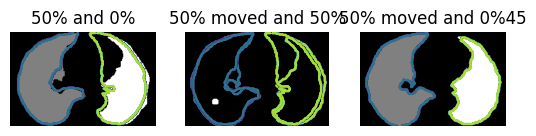

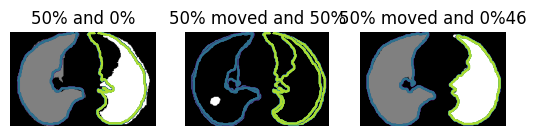

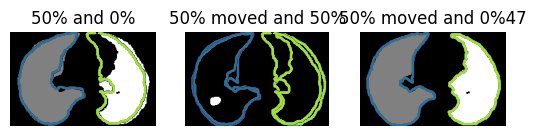

In [14]:
arrayCT_resampled = sitk.GetArrayFromImage(resampled_image)
count=0
for i in range(arraygtv_50.shape[-3]):
    if np.sum(arraygtv_50[i,:,:])>0:
        plt.subplot(131),plt.imshow(array00_lungmask[i,:,:],cmap='gray'),plt.axis("off")
        #plt.contour(arraygtv_50[i,:,:])
        plt.contour(array50_lungmask[i,:,:]),plt.title("50% and 0%")
        plt.subplot(132),plt.imshow(arraygtv_50[i,:,:],cmap='gray'),plt.axis("off")
        plt.contour(arrayCT_resampled[i,:,:]),plt.title("50% moved and 50%")
        plt.contour(array50_lungmask[i,:,:])
        plt.subplot(133),plt.imshow(array00_lungmask[i,:,:],cmap='gray'),plt.axis("off")
        #plt.contour(arrayGtv_resampled[i,:,:])
        plt.contour(arrayCT_resampled[i,:,:]),plt.title("50% moved and 0%"+str(i))
        plt.show()
        count+=1
        if count>3:
            break
        

In [15]:
deformation_field = sitk.Image(fixed_image.GetSize(), sitk.sitkVectorFloat64)
deformation_field.SetSpacing(fixed_image.GetSpacing())
deformation_field.SetOrigin(fixed_image.GetOrigin())
deformation_field.SetDirection(fixed_image.GetDirection())

# Initialize the deformation field with vectors pointing to the corresponding locations in the moving image
for x in range(fixed_image.GetWidth()):
    for y in range(fixed_image.GetHeight()):
        index = (x, y)
        for z in range(fixed_image.GetDepth()):
            index = (x, y, z)
            fixed_point = fixed_image.TransformIndexToPhysicalPoint(index)
            moving_point = final_transform.TransformPoint(fixed_point)
            deformation_vector = np.array(moving_point) - np.array(fixed_point)
            deformation_field.SetPixel(index, deformation_vector)

slice_index = 44  # Adjust this to the desired slice index
deformation_field_slice = sitk.Extract(deformation_field, [fixed_image.GetWidth(), fixed_image.GetHeight(), 0], [0, 0, 1])

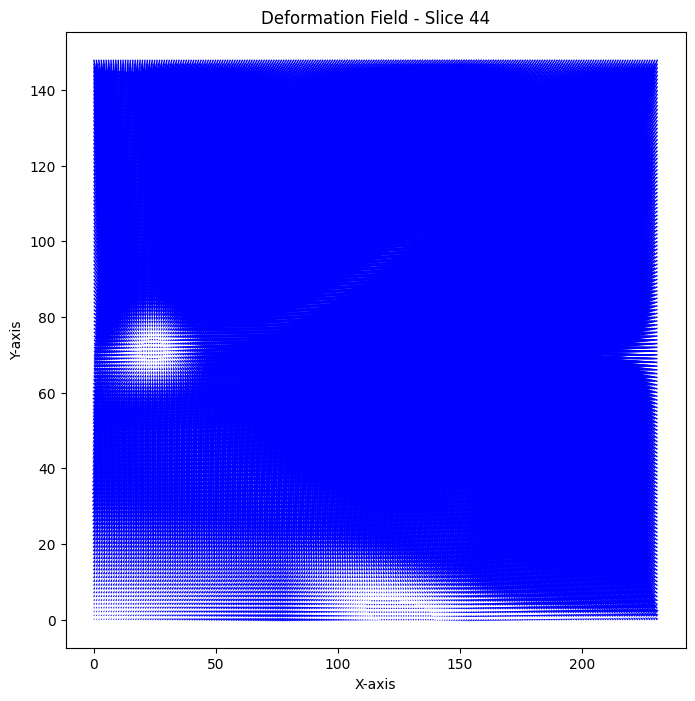

In [16]:
# Visualize the deformation field using quiver plot
deformation_array = sitk.GetArrayViewFromImage(deformation_field_slice)
x, y = np.meshgrid(np.arange(0, fixed_image.GetWidth()), np.arange(0, fixed_image.GetHeight()))

plt.figure(figsize=(8, 8))
plt.quiver(x, y, deformation_array[:, :, 0], deformation_array[:, :, 1], scale=20, color='b', angles='xy')
plt.title(f'Deformation Field - Slice {slice_index}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [24]:
#Resample 
gtv_crop_int = sitk.Cast(gtv_crop,sitk.sitkInt16)
resampled_gtv = sitk.Resample(gtv_crop_int, fixed_image, final_transform, sitk.sitkNearestNeighbor, 0, gtv_crop_int.GetPixelID())
#TO ARRAY
arrayGtv_resampled = sitk.GetArrayFromImage(resampled_gtv)


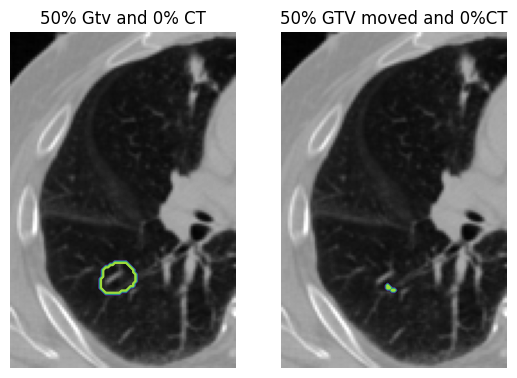

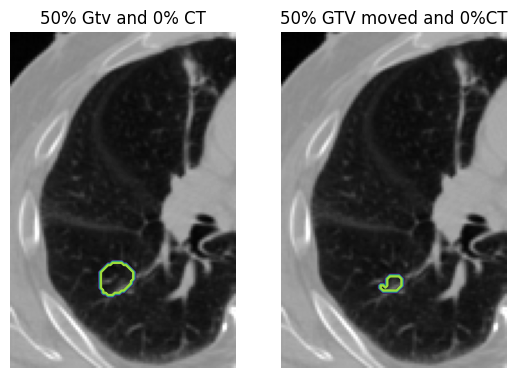

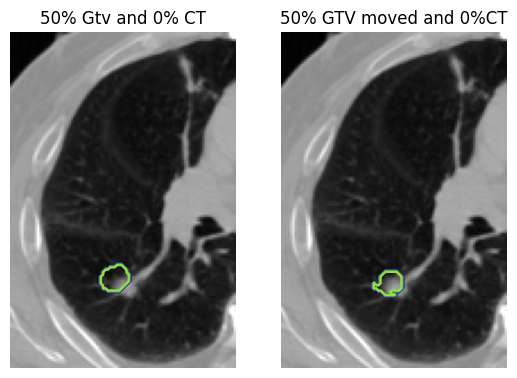

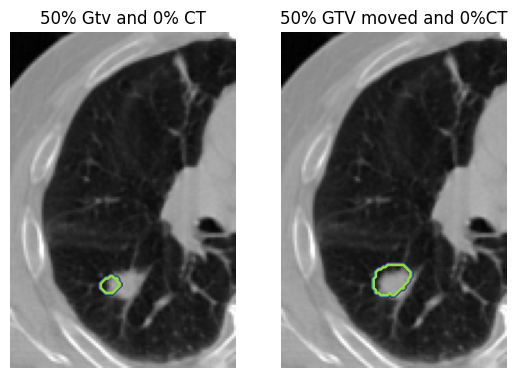

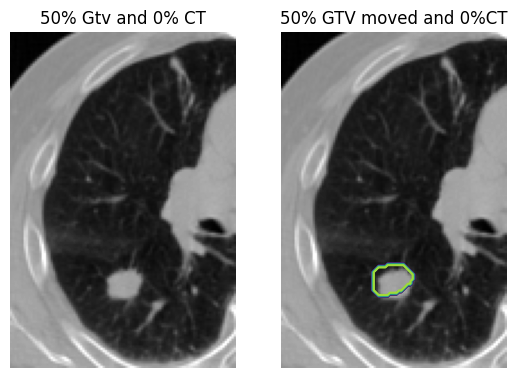

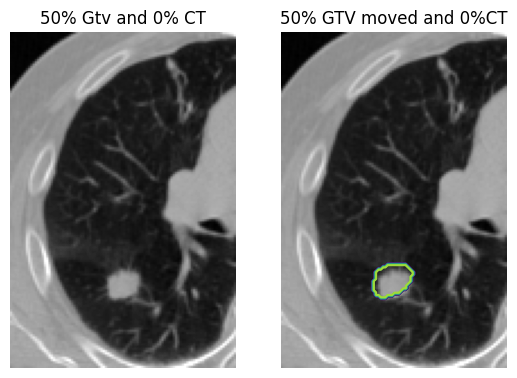

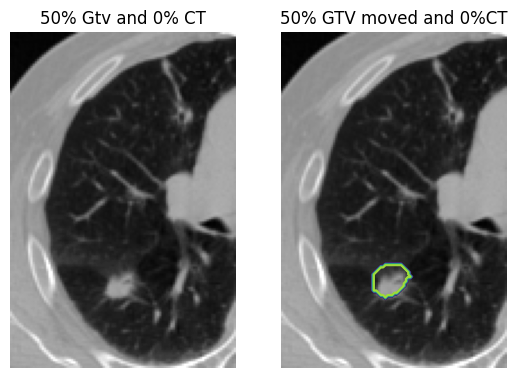

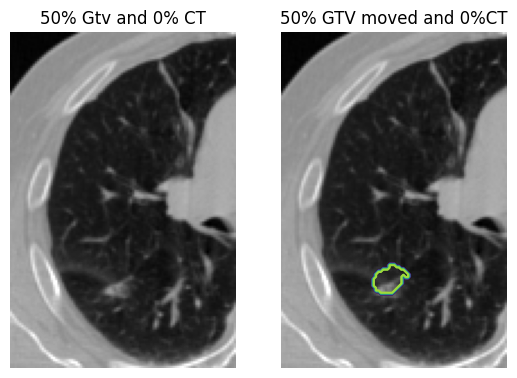

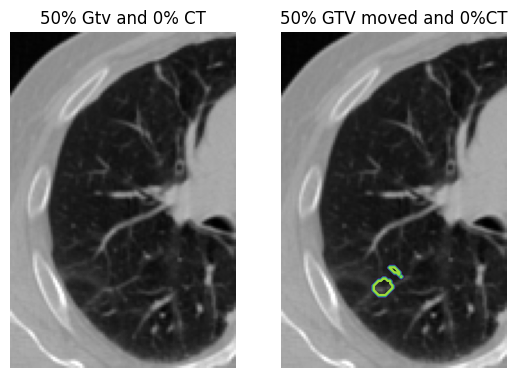

In [35]:
count=0
for i in range(arrayGtv_resampled.shape[-3]):
    if np.sum(arrayGtv_resampled[i,:,:])>0:
        plt.subplot(121),plt.imshow(sitk.GetArrayFromImage(image00_cropClamp[0:100,:,i]),cmap='gray'),plt.axis("off")
        plt.contour(arraygtv_50[i,:,0:100]),plt.title("50% Gtv and 0% CT")
        plt.subplot(122),plt.imshow(sitk.GetArrayFromImage(image00_cropClamp[0:100,:,i]),cmap='gray'),plt.axis("off")
        plt.contour(arrayGtv_resampled[i,:,0:100]),plt.title("50% GTV moved and 0%CT")
        plt.show()
        count+=1
        if count>10:
            break
        

In [30]:
i

51

In [28]:
unique_values = np.unique(arrayGtv_resampled.flatten())
unique_values

array([0, 1], dtype=int16)

In [ ]:
i